# MNIST Example
In this notebook we'll use the `vegans` library to generate some fake handwritten digits, using a generator and discriminator of our choice. 

### Initial Setup
First, some imports:

In [75]:
import os
import torch
import pickle

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

os.chdir("/home/thomas/Backup/Algorithmen/GAN-pytorch")
# vegans imports:

from vegans.GAN import WassersteinGAN
from vegans.utils.utils import plot_losses, plot_images

ngpu = 0

In [76]:
# do we have cuda?
print('Cuda is available: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda is available: True


Now download the mnist dataset and set the parameters below:

In [77]:
# Root directory for dataset
# This directory should contain "img_align_celeba"
datapath_train = "/home/thomas/Backup/Algorithmen/GAN-pytorch/data/mnist/train_images.pickle"
datapath_test = "/home/thomas/Backup/Algorithmen/GAN-pytorch/data/mnist/test_images.pickle"

# Size of z latent vector (i.e. size of generator input)
z_dim = [1, 4, 4]

# Input channels 
nc = 1

# Hidden layer channels for generator / critic
ngf = 8
ncf = 4

# Padding for mnist images (28x28) -> (32x32)
pad = 2

We need to create a `dataloader`, which is a `torch.utils.data.DataLoader` object:

In [78]:
""" Create dataset
"""
with open(datapath_train, "rb") as f:
    X_train, y_train = pickle.load(f)

with open(datapath_test, "rb") as f:
    X_test, y_test = pickle.load(f)
    
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)
X_train = np.pad(X_train, [(0, 0), (pad, pad), (pad, pad)], mode='constant').reshape(-1, 1, 32, 32)
X_test = np.pad(X_test, [(0, 0), (pad, pad), (pad, pad)], mode='constant').reshape(-1, 1, 32, 32)
print(X_train.shape, X_test.shape)
x_dim = X_train.shape[1:]

(60000, 1, 32, 32) (10000, 1, 32, 32)


Plot some of the training images:

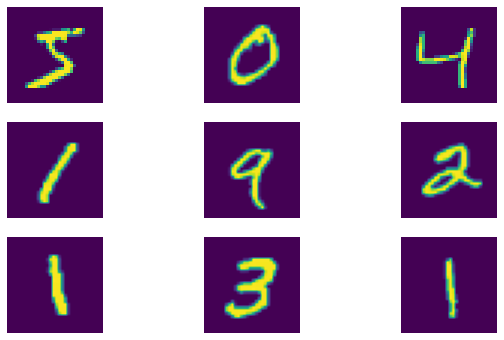

In [79]:
fig, axs = plot_images(images=X_train.reshape(-1, 32, 32))

### Definition of Generator and Discriminator
We'll specify the architecture of the generator and discriminator networks. It's difficult to know which architectures to choose before training. Here we used a architecture which proved to work.

Since we want to train a Wasserstein GAN, the output of the critic should be a real number and not a probability. Therefore we drop the last sigmoid.

In [90]:
""" Generator
"""
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.hidden_part = nn.Sequential(
            nn.ConvTranspose2d(z_dim[0], ngf * 8, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 5, 1, 2, bias=False),
        )
        self.output = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden_part(x)
        x = self.output(x)
        return x
    
""" Discriminator
"""
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.hidden_part = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ncf, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ncf, ncf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ncf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ncf * 2, ncf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ncf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ncf * 4, ncf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ncf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 2 x 2
            nn.Conv2d(ncf * 8, 1, 2, 1, 0, bias=False)
        )
        self.output = nn.Identity()

    def forward(self, x):
        x = self.hidden_part(x)
        x = self.output(x)
        return x
    
generator = Generator()
critic = Critic()

### Train our GAN
Build a Wasserstein GAN trainer, using default optimizers (we can also specify our own). To use a different GAN algorithm, just use the corresponding class (e.g., `VanillaGAN` for original GAN).

Here you can specify some optional GAN parameters, such as the latent space dimension `nz`, the number of samples to save (`fixed_noise_size`) and the optimizers (`optim`).

In [91]:
gan = WassersteinGAN(generator, critic, z_dim=z_dim, x_dim=x_dim, ngpu=ngpu, fixed_noise_size=20)

In [92]:
gan.summary()

Generator
Input shape:  (1, 4, 4)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 64, 4, 4]             576
       BatchNorm2d-2             [-1, 64, 4, 4]             128
              ReLU-3             [-1, 64, 4, 4]               0
   ConvTranspose2d-4             [-1, 32, 8, 8]          32,768
       BatchNorm2d-5             [-1, 32, 8, 8]              64
              ReLU-6             [-1, 32, 8, 8]               0
   ConvTranspose2d-7           [-1, 16, 16, 16]           8,192
       BatchNorm2d-8           [-1, 16, 16, 16]              32
              ReLU-9           [-1, 16, 16, 16]               0
  ConvTranspose2d-10            [-1, 8, 32, 32]           2,048
      BatchNorm2d-11            [-1, 8, 32, 32]              16
             ReLU-12            [-1, 8, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 32, 32]             200
     

Train the networks by calling the `fit()` method. Here you can specify some parameters for training like `eochs`, `save_model_every`, `save_images_every`, `print_every`, `batch_size` and others.

You can interrupt training at any time and still access train stats from within the `gan` object. You can resume training later.

In [93]:
gan.fit(X_train, epochs=20, print_every="0.25e", save_losses_every=10, enable_tensorboard=False)

------------------------------------------------------------
EPOCH: 1
------------------------------------------------------------


/home/thomas/miniconda3/envs/pytorch38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thomas/miniconda3/envs/pytorch38/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Step: 1875 / 18750 (Epoch: 1 / 10, Batch: 1875 / 1875)
------------------------------------------------------------
Generator: -0.00013274724187795073
Adversariat: -0.00026165490271523595
Adversariat_fake: 0.0001327472273260355
Adversariat_real: -0.0006560570327565074


Time left: ~3.18 minutes (Batches remaining: 16875).


------------------------------------------------------------
EPOCH: 2
------------------------------------------------------------
Step: 3750 / 18750 (Epoch: 2 / 10, Batch: 1875 / 1875)
------------------------------------------------------------
Generator: 0.006735399831086397
Adversariat: -0.004488452337682247
Adversariat_fake: -0.006735399831086397
Adversariat_real: -0.002241505077108741


Time left: ~2.862 minutes (Batches remaining: 15000).


------------------------------------------------------------
EPOCH: 3
------------------------------------------------------------
Step: 5625 / 18750 (Epoch: 3 / 10, Batch: 1875 / 1875)
------------------------------------

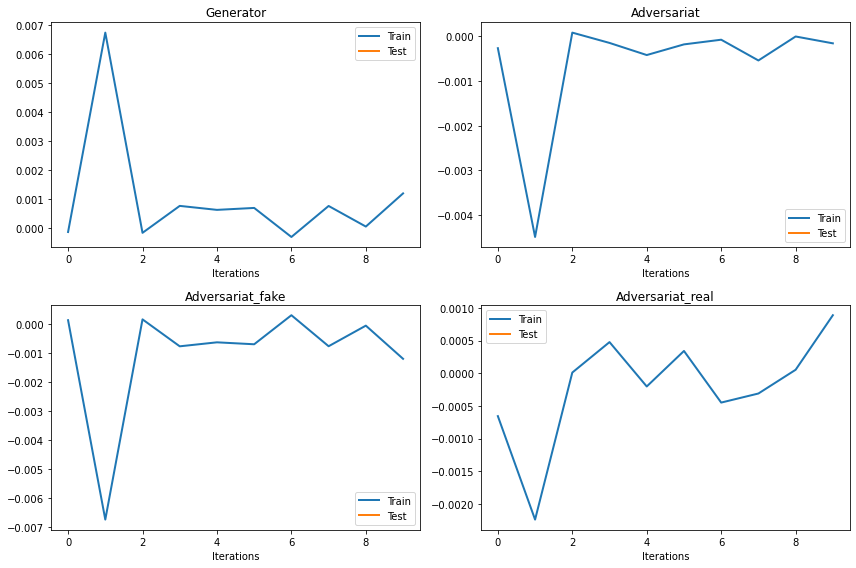

In [95]:
samples, losses = gan.get_training_results()
fig, axs = plot_losses(losses)

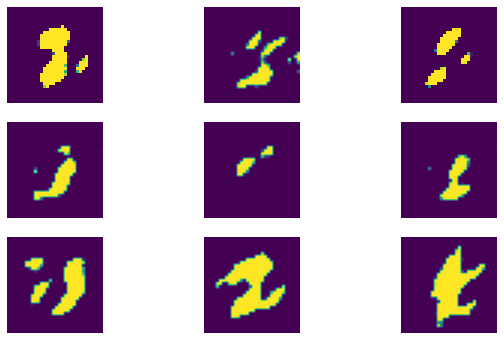

(<Figure size 720x432 with 9 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>], dtype=object))

In [97]:
fig, axs = plot_images(samples.reshape(-1, 32, 32))